<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-4--job-resume-improvement/text-similarity-analysis/01_binary_vector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Measuring text similarity using binary vector

In this notebook, we focus on a basic NLP problem: **measuring the similarity between two texts using binary vector**. 

The string-to-string comparision is too slow to execute across thousands of complicated
texts. Perhaps we can speed up the computation by somehow running it using NumPy.

However, NumPy is intended to process numbers, not words, so we cannot use the
library unless we replace all words with numeric values.

Can we swap out words for numbers? Yes!

We simply need to iterate over all words in
all texts and assign each unique $i^{th}$ word a value of $i$. 

The mapping between words
and their numeric values can be stored in a Python dictionary. We’ll refer to this dictionary
as our vocabulary. 

Let’s build a vocabulary(word-to-index) that covers all the words in our three
texts. 

We’ll also create a complementary `index_to_word` dictionary, which maps the
numeric values back to words.

>This technique is commonly referred to as the `bag-of-words` technique.

##Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from collections import defaultdict
from collections import Counter
import time
import numpy as np
import pandas as pd

from scipy.spatial.distance import euclidean
from numpy.linalg import norm

import seaborn as sns
import matplotlib.pyplot as plt

##Preparing text 

Suppose we want to compare three simple texts:

```text
text1—She sells seashells by the seashore
text2—“Seashells! The seashells are on sale! By the seashore.”
text3—She sells 3 seashells to John, who lives by the lake.
```

Our goal is to determine whether `text1` is more similar to `text2` or to `text3`.



In [ ]:
# Assigning texts to variables
text1 = "She sells seashells by the seashore."
text2 = '"Seashells! The seashells are on sale! By the seashore."'
text3 = "She sells 3 seashells to John, who lives by the lake."

Now we need to quantify the differences between texts.

In [ ]:
# Splitting texts into words
words_lists = [text.split() for text in [text1, text2, text3]]

In [ ]:
# Removing case sensitivity and punctuation
def simplify_text(text):
  for punctuation in ['.', ',', '!', '?', '"']:
    text = text.replace(punctuation, "")
  return text.lower()

In [ ]:
# Converting word lists to sets
words_sets = [set(words) for words in words_lists]

##Creating vocabulary

Let’s build a vocabulary that covers all the words in our three
texts.

In [ ]:
# Assigning words to numbers in a vocabulary
words_set1, words_set2, words_set3 = words_sets
total_words = words_set1 | words_set2 | words_set3

# create word-to-index vocabulary
vocabulary = {word: i for i, word in enumerate(total_words)}
# create index-to-word vocabulary
index_to_word = {value: word for word, value in vocabulary.items()}

print(f"Our vocabulary contains {len(vocabulary)} words. This vocabulary is:\n{vocabulary}")

Our vocabulary contains 19 words. This vocabulary is:
{'who': 0, 'lake.': 1, 'She': 2, 'on': 3, 'seashells': 4, 'John,': 5, 'by': 6, 'sells': 7, 'seashore."': 8, 'the': 9, 'lives': 10, '3': 11, 'to': 12, 'seashore.': 13, '"Seashells!': 14, 'By': 15, 'The': 16, 'sale!': 17, 'are': 18}


In [ ]:
index_to_word[4]

'seashells'

##Creating binary vector

Given our vocabulary, we can convert any text into a one-dimensional array of numbers.

Mathematically, a 1D numeric array is called a vector. 

Hence, **the process of converting
text into a vector is called text vectorization**.

The simplest way to vectorize text is to create a vector of binary elements. Each index
of that vector corresponds to a word in the vocabulary. 

Hence, the vector size equals
the vocabulary size, even if some vocabulary words are missing from the associated
text. If the word at index $i$ is missing from the text, the $i^{th}$ vector element is set to 0.
Otherwise, it is set to 1. 

Consequently, each vocabulary index in the vector maps to
either 0 or 1.

Let’s use binary vectorization to convert all texts into NumPy arrays.

We’ll store the
computed vectors in a 2D vectors list, which can be treated like a table. The table’s
rows will map to texts, and its columns will map to the vocabulary.

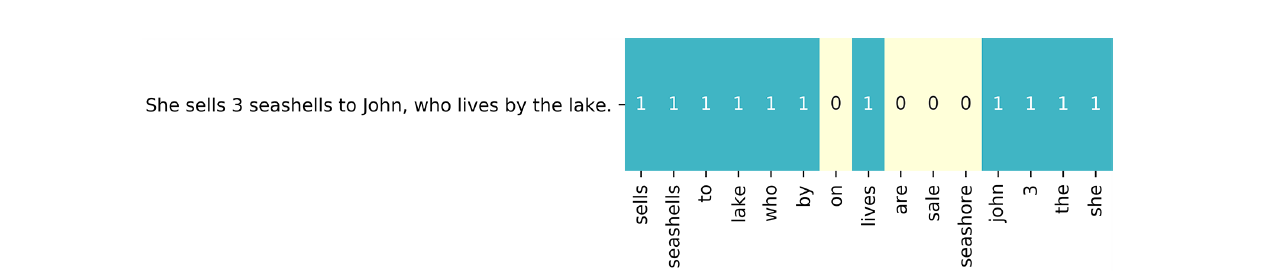

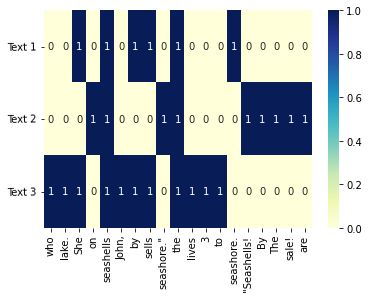

In [ ]:
# Transforming words into binary vectors
vectors = []
for i, words_set in enumerate(words_sets, 1):
  # Generates an array of 0s
  vector = np.array([0] * len(vocabulary))
  for word in words_set:
    vector[vocabulary[word]] = 1
  vectors.append(vector)

sns.heatmap(vectors, annot=True, cmap="YlGnBu", 
             xticklabels=vocabulary.keys(),
             yticklabels=["Text 1", "Text 2", "Text 3"])
plt.yticks(rotation=1)
plt.show()

##Text similarity with binary vector

Using our table, we can easily tell which words are shared between which texts.

Our binary vector representation allows us to extract shared words numerically.

Suppose we wish to know whether the word in column $i$ is present both in `text1` and
`text2`.

In [ ]:
# Finding shared words using vector arithmetic
vector1, vector2 = vectors[:2]
for i in range(len(vocabulary)):
  if vector1[i] * vector2[i]:
    shared_word = index_to_word[i]
    print(f"'{shared_word}' is present in both texts 1 and 2")

'seashells' is present in both texts 1 and 2
'the' is present in both texts 1 and 2


Meanwhile, the sum of every zero instance equals 0. 

Therefore, we can compute the
shared word count merely by summing the pairwise product of `vector1[i]` and
`vector2[i]` across every possible $i$.

In [ ]:
# Counting shared words using vector arithmetic
shared_word_count = sum(vector1[i] * vector2[i] for i in range(len(vocabulary)))
assert shared_word_count == len(words_set1 & words_set2)

The sum of the pairwise products across all vector indices is called the dot product.

In [ ]:
# Computing a vector dot product using NumPy
assert vector1.dot(vector2) == shared_word_count
assert vector1 @ vector2 == shared_word_count

Stated more concisely, `vector1 @ vector1` should equal the number of unique words
in `text1`, which is also equal to `len(words_set1)`. 

Let’s confirm.

In [ ]:
assert vector1 @ vector1 == len(words_set1)
assert vector2 @ vector2 == len(words_set2)

We are able to compute both shared word count and total unique word count using
vector dot products.

Essentially, we can compute the Jaccard similarity using only
vector operations. 

This vectorized implementation of Jaccard is called the Tanimoto
similarity.

In [ ]:
# Computing text similarity using vector arithmetic
def tanimoto_similarity(vector_a, vector_b):
  num_shared = vector_a @ vector_b
  num_total = vector_a @ vector_a + vector_b @ vector_b - num_shared
  return num_shared / num_total

In [ ]:
for i, text in enumerate([text2, text3], 1):
  print(f"text{i}: {text}")
  print(f"vectors{i}: {vectors[i]}")
  similarity = tanimoto_similarity(vector1, vectors[i])
  print(f"similarity: {similarity}")

text1: "Seashells! The seashells are on sale! By the seashore."
vectors1: [0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 1]
similarity: 0.15384615384615385
text2: She sells 3 seashells to John, who lives by the lake.
vectors2: [1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0]
similarity: 0.4166666666666667


What
would happen if we inputted two arrays with values other than 0 or 1? 

Technically,
the function should return a similarity, but would that similarity make sense? 

For
instance, vectors `[5, 3]` and `[5, 2]` are nearly identical. We expect their similarity to be nearly equal to 1.

Let’s test our expectations by inputting the vectors.

In [ ]:
# Computing the similarity of non-binary vectors
non_binary_vector1 = np.array([5, 3])
non_binary_vector2 = np.array([5, 2])

similarity = tanimoto_similarity(non_binary_vector1, non_binary_vector2)
print(f"The similarity of 2 non-binary vectors is {similarity}")

The similarity of 2 non-binary vectors is 0.96875


The outputted value is nearly equal to 1. 

Thus, `tanimoto_similarity` has successfully
measured the similarity between two nearly identical vectors. The function can analyze
non-binary inputs. 

This means **we can use non-binary techniques to vectorize our
texts before comparing their contents**.